# Quickstart: Use Cases and Examples with Synthetic Data
---
This notebook provides an example of conducting OPE of several different evaluation policies and synthetic logged bandit feedback data.

Our example with synthetic data contains the follwoing four major steps:
- (1) Synthetic Data Generation
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [https://github.com/st-tech/zr-obp/tree/master/examples/examples_with_synthetic](https://github.com/st-tech/zr-obp/tree/master/examples/examples_with_synthetic) 
for a more sophisticated example of the evaluation of OPE with synthetic datasets.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

In [2]:
# obp version
print(obp.__version__)

0.3.2


## (1) Synthetic Data Generation
We prepare easy-to-use synthetic data generator: `SyntheticBanditDataset` class in the dataset module.

It takes number of actions (`n_actions`), dimension of context vectors (`dim_context`), reward function (`reward_function`), and behavior policy (`behavior_policy_function`) as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [3]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_train, n_rounds_test = 100000, 100000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

# `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
bandit_feedback_train

{'n_rounds': 100000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [ 1.36946256,  0.58727761, -0.69296769, -0.27519988, -2.10289159],
        [-0.27428715,  0.52635353,  1.02572168, -0.18486381,  0.72464834],
        [-1.25579833, -1.42455203, -0.26361242,  0.27928604,  1.21015571]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([7, 4, 0, ..., 7, 9, 6]),
 'position': array([0,

## (2) Off-Policy Learning
After generating synthetic data, we now train some candidate evaluation policies using the training set. <br>

We use *IPW Learner* implemented in the policy module to train evaluation policies. 
We also use *RandomForestClassifier* and *LogisticRegression* implemented in scikit-learn for base machine learning methods.

In [4]:
# define IPWLearner with Logistic Regression as its base ML model
evaluation_policy_a = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_a.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_a = evaluation_policy_a.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1, # temperature hyperparameter
)

In [5]:
# define IPWLearner with Random Forest as its base ML model
evaluation_policy_b = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_b.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_b = evaluation_policy_b.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1, # temperature hyperparameter
)

In [6]:
# define Uniform Random Policy as a baseline evaluation policy
evaluation_policy_c = Random(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
)
# compute the action choice probabililties for the test set of the synthetic logged bandit feedback
action_dist_c = evaluation_policy_c.compute_batch_action_dist(
    n_rounds=bandit_feedback_test["n_rounds"]
)

## (3) Off-Policy Evaluation (OPE)
OPE attempts to estimate the performance of evaluation policies using their action choice probabilities.

Here, we use the **InverseProbabilityWeighting (IPW)**, **DirectMethod (DM)**, and **Doubly Robust (DR)** estimators and estimate the performances of the pre-trained evaluation policies.
 
Finally, we summarize and visualize the results of OPE and evaluate their estimation accuracies.

In [7]:
# estimate the mean reward function by using ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    action_context=dataset.action_context,
    base_model=LogisticRegression(random_state=12345),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [8]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.632676          0.629289          0.636027
dm   0.611849          0.610647          0.613033
dr   0.632853          0.629308          0.636341 



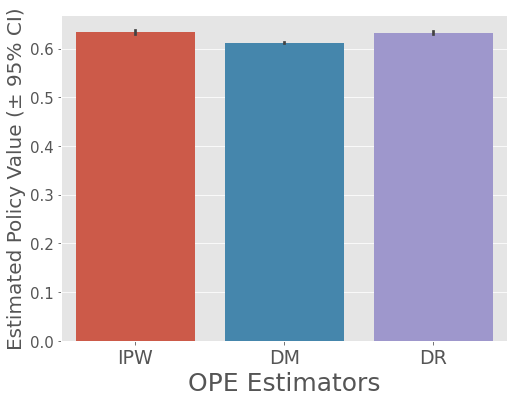

In [9]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_dist=action_dist_a,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_a, '\n')
# visualize estimated policy values of IPWLearner with Logistic Regression by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_a,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    random_state=12345,
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.638988          0.634255          0.643433
dm   0.611612          0.610197          0.612811
dr   0.638474          0.635201          0.642306 



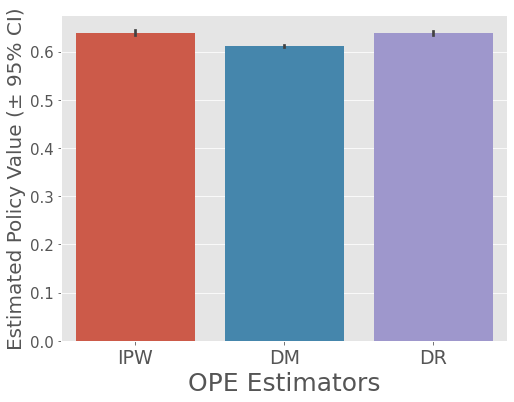

In [10]:
# estimate the policy value of IPWLearner with Random Forest by OPE estimators
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    action_dist=action_dist_b,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_b, '\n')
# visualize estimated policy values of IPWLearner with Random Forest by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_b,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    random_state=12345,
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.606485          0.603209          0.609374
dm   0.606199          0.604976          0.607331
dr   0.606991          0.604044          0.610438 



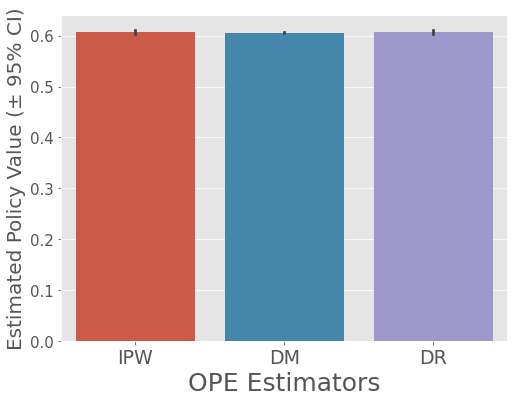

In [11]:
# estimate the policy value of Uniform Random
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    action_dist=action_dist_c,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_c, '\n')
# visualize estimated policy values of Uniform Random by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_c,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    random_state=12345,
)

Our OPE procedure estimates that IPWLearners largely outperform the Uniform Random policy.

Moreover, IPWLearner with Random Forest seems to be the best one.

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracies of OPE estimators.

With the synthetic data, we can know the ground-truth policy values of the evaluation policies. 
Therefore, we can compare the estimated policy values by OPE estimators with the ground-turths to evaluate OPE estimators.

In [12]:
# we first calculate the ground-truth policy values of the three evaluation policies
# using the expected rewards contained in the bandit feedback dictionary
expected_rewards = bandit_feedback_test['expected_reward']
ground_truth_a = np.average(expected_rewards, weights=action_dist_a[:, :, 0], axis=1).mean()
ground_truth_b = np.average(expected_rewards, weights=action_dist_b[:, :, 0], axis=1).mean()
ground_truth_c = np.average(expected_rewards, weights=action_dist_c[:, :, 0], axis=1).mean()

print(f'ground-truth policy value of IPWLearner with Logistic Regression: {ground_truth_a}')
print(f'ground-truth policy value of IPWLearner with Random Forest: {ground_truth_b}')
print(f'ground-truth policy value of Unifrom Random: {ground_truth_c}')

ground-truth policy value of IPWLearner with Logistic Regression: 0.632011615352198
ground-truth policy value of IPWLearner with Random Forest: 0.6385692120839856
ground-truth policy value of Unifrom Random: 0.606060477451349


In fact, IPWLearner with Random Forest reveals the best performance among the three evaluation policies.

Using the above ground-truths, we can now evaluate the estimation accuracy of the estimators.

In [13]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of IPWLearner with Logistic Regression and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee_a = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_a,
    action_dist=action_dist_a,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower is better)
relative_ee_a

,relative-ee
ipw,0.001501
dm,0.031816
dr,0.001353


In [14]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of IPWLearner with Random Forest and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee_b = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_b,
    action_dist=action_dist_b,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower is better)
relative_ee_b

,relative-ee
ipw,0.000881
dm,0.042184
dr,0.000229


In [15]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of Uniform Random and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee_c = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_c,
    action_dist=action_dist_c,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower is better)
relative_ee_c

,relative-ee
ipw,0.001044
dm,0.000219
dr,0.001391


Please see [https://github.com/st-tech/zr-obp/tree/master/examples/examples_with_synthetic](https://github.com/st-tech/zr-obp/tree/master/examples/examples_with_synthetic) for a more sophisticated example of the evaluation of OPE with synthetic data.